## Movie Production Analysis by Genre

_Ryan Harper_

__Data Source:__ https://www.kaggle.com/tmdb/tmdb-movie-metadata/data

The dataset was pulled from Kaggle.com (an open source data science website). The user who uploaded the data, scraped content from IMDB's website. The user chose to store the movie title, budget, earnings, genre list, average rating, and the popularity score (calculated by the movie page views). This data is interesting because it looks at a large number of movies and includes data that reports on relative financial success, movie rating, and movie popularity. A movie producer could show potential investors how a new movie idea would correlate to existing successful movies while estimating basic trends for financial success, ratings, and popularity.

__Questions to explore:__ Is there a relationship between budget and revenue? Is there a normal distribution of revenue per genre? Is there a relationship between gross profits and genre type? 

####  Part 1: Import libraries, import data, clean data, review basic data

In [1]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import calendar
from matplotlib.pyplot import subplots, show
import ast
%matplotlib inline

pd.set_option('show_dimensions', False)
np.warnings.filterwarnings('ignore')

In [2]:
# import data, add gross revenue column, and delete homepage/overview columns
moviedata = pd.read_csv('tmdb_5000_movies.csv', encoding = "ISO-8859-1") 
moviedata['gross'] = moviedata['revenue'] - moviedata['budget']
del moviedata['homepage']
del moviedata['overview']
del moviedata['original_title']

In [3]:
# function for returning list of unique values in column
def find_set(series, unique=[]):
    for fulllist in series:
        fulllist = ast.literal_eval(fulllist)
        for fulldict in fulllist:
            if 'name' in fulldict:
                unique.append(fulldict['name'])          
    return set(unique)

# function for converting dictionaries to simple lists in columns
def name_fix(fulllist):
    try:
        glist=[]
        fulllist = ast.literal_eval(fulllist)
        for fulldict in fulllist:
            if 'name' in fulldict:
                glist.append(fulldict['name'])
        return ', '.join(glist)
    except (SyntaxError, ValueError, TypeError) as e:
        return fulllist

In [4]:
# creates list of unique values for specific columns with string data
un_genre = list(find_set(moviedata.genres))
un_country = list(find_set(moviedata.production_countries))
un_language = list(find_set(moviedata.spoken_languages))
un_keywords = list(find_set(moviedata.keywords))
un_companies = list(find_set(moviedata.production_companies))

# runs the name fix function to make the dataset easier to read
for column in moviedata:
    moviedata[column] = moviedata[column].apply(name_fix)

# reporting of data
print("COUNTRIES: {}, GENRES: {}, LANGUAGES: {}, COMPANIES: {}".format(len(un_country),len(un_genre),len(un_language),len(un_companies)))
print("BUDGET MAX: ${:,.2f} REVENUE MAX: ${:,.2f} GROSSING MAX: ${:,.2f}".format(moviedata['budget'].max(),moviedata['revenue'].max(),moviedata['gross'].max()))    
print("BUDGET MEAN: ${:,.2f} REVENUE MEAN: ${:,.2f} GROSSING MEAN: ${:,.2f}".format(moviedata['budget'].mean(),moviedata['revenue'].mean(),moviedata['gross'].mean()))          
moviedata.head()

COUNTRIES: 108, GENRES: 20, LANGUAGES: 170, COMPANIES: 15000
BUDGET MAX: $380,000,000.00 REVENUE MAX: $2,787,965,087.00 GROSSING MAX: $2,550,965,087.00
BUDGET MEAN: $29,045,039.88 REVENUE MEAN: $82,260,638.65 GROSSING MEAN: $53,215,598.78


,budget,genres,id,keywords,original_language,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,gross
0,237000000,"Action, Adventure, Fantasy, Science Fiction",19995,"culture clash, future, space war, space colony...",en,150.437577,"Ingenious Film Partners, Twentieth Century Fox...","United States of America, United Kingdom",1987,2787965087,162.0,"English, Español",Released,Enter the World of Pandora.,Avatar,7.2,11800,2550965087
1,300000000,"Adventure, Fantasy, Action",285,"ocean, drug abuse, exotic island, east india t...",en,139.082615,"Walt Disney Pictures, Jerry Bruckheimer Films,...",United States of America,2007-05-19,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,661000000
2,245000000,"Action, Adventure, Crime",206647,"spy, based on novel, secret agent, sequel, mi6...",en,107.376788,"Columbia Pictures, Danjaq, B24","United Kingdom, United States of America",1979,880674609,148.0,"Français, English, Español, Italiano, Deutsch",Released,A Plan No One Escapes,Spectre,6.3,4466,635674609
3,250000000,"Action, Crime, Drama, Thriller",49026,"dc comics, crime fighter, terrorist, secret id...",en,112.312950,"Legendary Pictures, Warner Bros., DC Entertain...",United States of America,2012-07-16,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106,834939099
4,260000000,"Action, Adventure, Science Fiction",49529,"based on novel, mars, medallion, space travel,...",en,43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124,24139100


There are ~4800 movies, 20 genre types, 108 countries, and ~170 languages.<br>The highest budget movie is  \$380,000,000.00. Highest revenue is  \$2,787,965,087.00. The highest grossing was  \$2,550,965,087.00 (Avatar). <br>The average budget was  \$29,045,039.88. The average revenue was  \$82,260,638.65 and the average gross was  \$53,215,598.78.

####  Part 2: Create new genre dataframes and check for normal distribution

In [5]:
# function for checking if genre exists in a column
def genre_check(value):
    for member in un_genre:
        if member in value:
            return True
        else:
            return False

In [6]:
# creates temp columns for True/False check of each genre and deletes main genre column
for column in un_genre:
    moviedata[column] = moviedata.genres.apply(lambda value: column in value)    
del moviedata['genres']

In [7]:
# creates new dataframes for each genre and puts into genredict
genredict = {}
gross_profits = pd.DataFrame()

for column in un_genre:
    df = moviedata[moviedata[column] == True]
    genredict[column] = df.drop(un_genre, axis=1, inplace=False)    

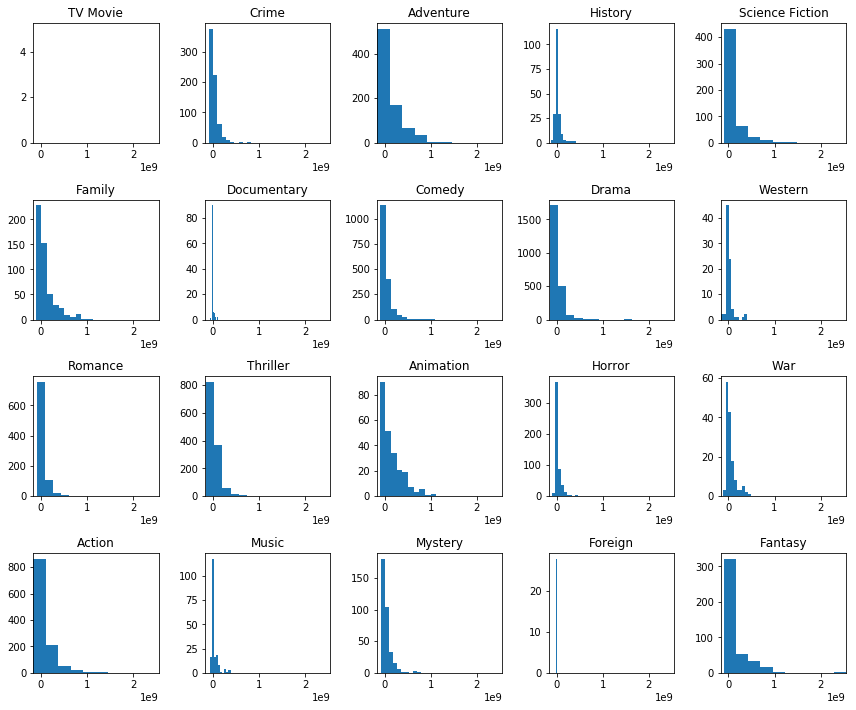

In [8]:
# hist plot of diff genres gross profits
i = 1
fig=plt.figure(figsize=(12,12))

xmin = moviedata['gross'].min()
xmax = moviedata['gross'].max()
for genre in genredict:
    plt.subplot(5, 5, i)
    
    i = i + 1
    plt.hist(genredict[genre]['gross'],bins=10)
    plt.xlim(xmin,xmax)
    plt.title(genre)
    
plt.tight_layout()
plt.show()

Most genres appear to be left skewed with a few exceptions that appear to be more normalized.

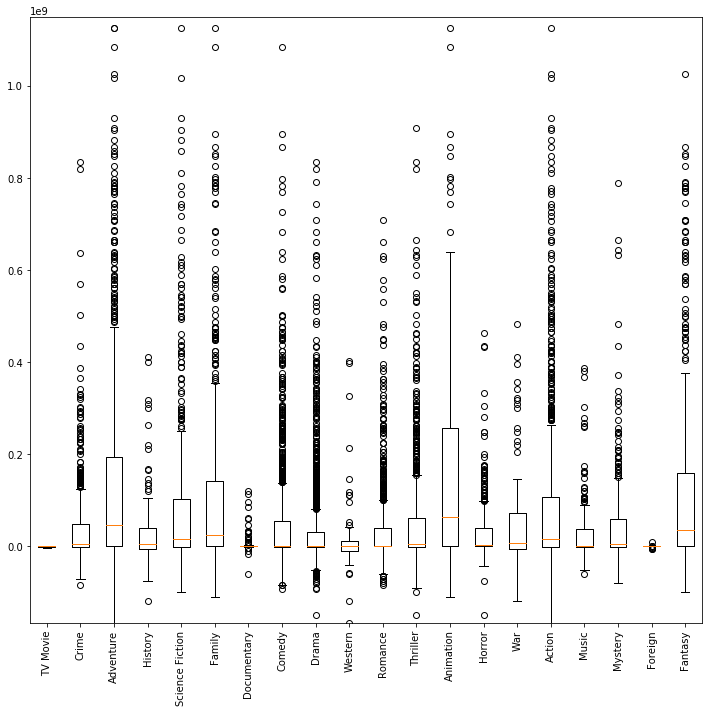

In [9]:
def ser_con(genre): return genredict[genre]['gross']

plt.figure(figsize=(10,10))
plt.boxplot(list(map(ser_con, un_genre)))
plt.xticks(list(range(1,21)), un_genre, rotation=90)
plt.ylim(moviedata['gross'].min(), moviedata['gross'].max()*.45)
plt.tight_layout()
plt.show()

Foreign and TV movie genres don't appear to have much variance.<br>Animation films appear to have the best gross profit range. <br>Romance, Horror, and Music films seem to trend towards a positive gross profit albeit their upper quartile ranges are smaller than other high grossing genres.<br> The lower quartile range of Action and Adventures films seem to run in negative gross profits.

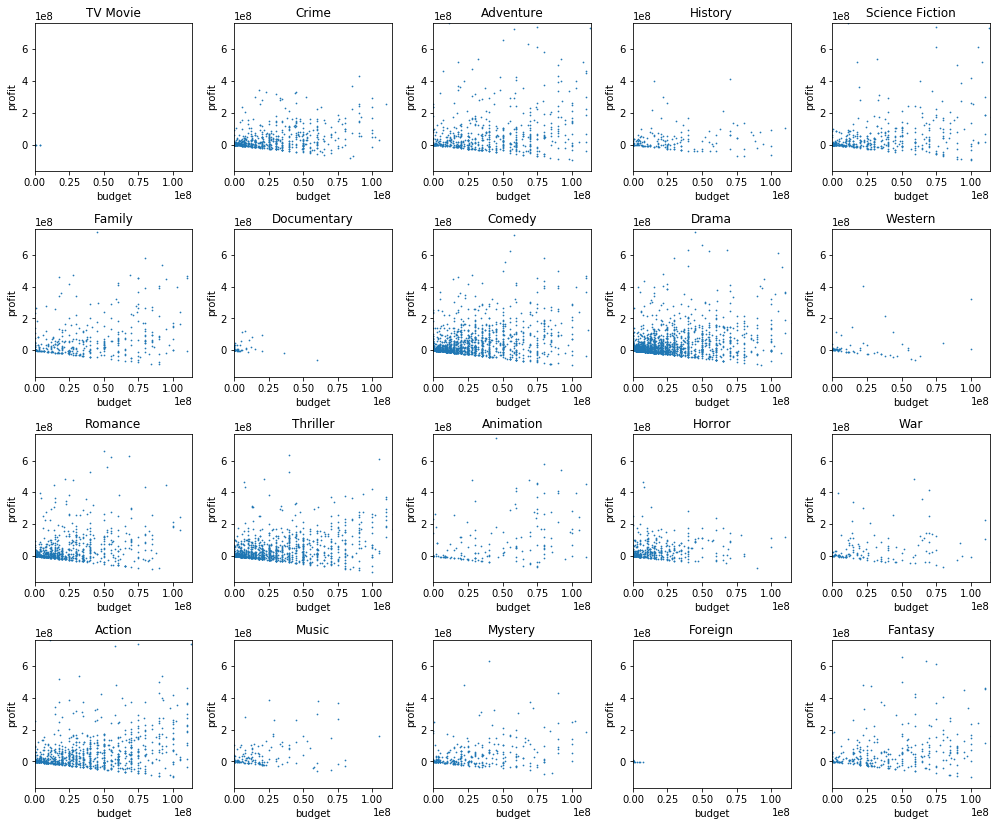

In [10]:
# plot of expense(x) to revenue(y)
correlation = {}
i = 1
fig=plt.figure(figsize=(14,14))

xmin = moviedata['budget'].min()
xmax = moviedata['budget'].max()*.3

ymin = moviedata['gross'].min()
ymax = moviedata['gross'].max()*.3

for genre in genredict:
    plt.subplot(5, 5, i)
    i = i + 1
    plt.scatter(genredict[genre]['budget'],genredict[genre]['gross'],.5)
    
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.title(genre)
    plt.xlabel('budget')
    plt.ylabel('profit')
    
    correlation[genre] = (genredict[genre]['budget'].corr(genredict[genre]['gross']))
    
plt.tight_layout()
plt.show()

In [11]:
print('--CORRELATION BETWEEN EXPENSE AND PROFIT--')
for key in correlation:
    print("{}: {}".format(key, correlation[key]))

--CORRELATION BETWEEN EXPENSE AND PROFIT--
TV Movie: -1.0
Crime: 0.5734102651868525
Adventure: 0.5697632541939066
History: 0.20388005934093092
Science Fiction: 0.5869991329566364
Family: 0.5564977453231562
Documentary: 0.006147059539220788
Comedy: 0.5064179319094227
Drama: 0.45802522058523343
Western: 0.07376500161112028
Romance: 0.4364316327475838
Thriller: 0.5528890538166866
Animation: 0.5227096890624338
Horror: 0.30977866084620803
War: 0.27337282652163836
Action: 0.6135578735709715
Music: 0.41796510667726766
Mystery: 0.4885524462987987
Foreign: -0.6807663647926859
Fantasy: 0.5919416715721276


In [12]:
# creates a new dataframe based on genres
dfSeries = {}
intcolumns = ['budget','popularity','revenue','runtime','vote_average','gross']
for col in intcolumns:
    poplist = []
    for genre in un_genre:
        poplist.append(moviedata[genre] == True)

    serlist = []
    for ser in poplist:
        serlist.append(moviedata.loc[ser, col].mean())
        
    dfSeries[col] = serlist
    
dfGenre = pd.DataFrame(dfSeries)
dfGenre.index = un_genre

dfGenre.describe()

,budget,gross,popularity,revenue,runtime,vote_average
count,2.000000e+01,2.000000e+01,20.000000,2.000000e+01,20.000000,20.000000
mean,3.172614e+07,5.741169e+07,21.770989,8.913783e+07,107.724656,6.173921
std,2.078983e+07,4.781927e+07,11.113390,6.799229e+07,12.255761,0.278476
min,6.580884e+05,-1.150000e+06,0.686787,0.000000e+00,85.625000,5.626590
25%,1.921051e+07,2.863331e+07,17.074236,4.790346e+07,99.347209,6.009644
50%,2.887664e+07,4.283355e+07,20.574595,6.872008e+07,109.485574,6.180978
75%,5.091732e+07,9.242450e+07,28.609732,1.440240e+08,110.796463,6.344325
max,6.646590e+07,1.592271e+08,39.268042,2.256930e+08,135.989848,6.719797


####  Part 3: Conclusion

From looking at the data, there does seem to be variance between genres with regards to budget, revenue, and gross profit. This could help investors decide which films they would want to invest in.<br>
<br>For example, a potential investor might look at the data to conclude: <li>Horror films in the past had a high likelihood of profiting from the film but that the total profit wasn't marginally greater than the budget of the film. <li>Action and Adventures films, appear to have a high risk, high reward with regards to profit.<li>Animation films seem to have the highest average gross profit.